# Implementazione del task 2 - Data Profiling

Prima di iniziare un task di data mining dovrebbero essere eseguite varie analisi preliminari sul Data Store allo scopo di:
1. Rilevare incongruenze (dati che presentano rumore/errori) e decidere come affrontarle.
2. Determinare la fattibilità dei modelli di data mining che si ha in mente di utilizzare nei task successivi.
3. Escludere informazioni banali a scapito del tempo di calcolo e del reale apporto di nuova conoscenza.

In [1]:
# IMPORT
import nbimporter
from pandas.plotting import parallel_coordinates
import ETLBasics_t1 as task1
import datetime
import dateutil as du
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# VARIABILI
PATH = './pmdata/'
want_normalize = True  # normalizzazione min-max per rendere i plot più interpretabili
people = [1,2,3]

### Implementazione del task 1

In [3]:
sedentary_minutes = task1.sedentary_minutes_to_df(PATH, people)
sleep_0, sleep_1 = task1.sleep_to_df(PATH, people)
exercise_0, exercise_1 = task1.exercise_to_df(PATH, people)
lightly_active_minutes = task1.lightly_active_minutes_to_df(PATH, people)
time_in_heart_rate_zones = task1.time_in_heart_rate_zones_to_df(PATH, people)
moderately_active_minutes = task1.moderately_active_minutes_to_df(PATH, people)
very_active_minutes = task1.very_active_minutes_to_df(PATH, people)
resting_heart_rate = task1.resting_heart_rate_to_df(PATH, people)
srpe = task1.srpe_to_df(PATH, people)
wellness = task1.wellness_to_df(PATH, people)
injury = task1.injury_to_df(PATH, people)

try:
    steps = pd.read_pickle("dataframes/steps.pkl").loc[people]
    distance = pd.read_pickle("dataframes/distance.pkl").loc[people]
    calories = pd.read_pickle("dataframes/calories.pkl").loc[people]
    heart_rate = pd.read_pickle("dataframes/heart_rate.pkl").loc[people]
except:
    steps = task1.steps_to_df(PATH, people)
    distance = task1.distance_to_df(PATH, people)
    calories = task1.calories_to_df(PATH, people)
    heart_rate = task1.heart_rate_to_df(PATH, people)

In [4]:
def min_max_norm(df, fillNaNwith=1):
    '''
    Esegue la normalizzazione min max: Per ogni i (X[i] - X.min) / (X.max - X.min)
    Se ci sono dei NaN questi vengono sostituiti col valore indicato dal parametro fillNaNwith
    '''
    tmp = (df-df.min())/(df.max()-df.min())
    tmp.fillna(value=fillNaNwith, inplace=True)
    return tmp

def get_continuous_attributes(df):
    '''
    Estrae il nome delle colonne che sono attributi continui. Per farlo si usa l'attributo dtype della colonna.
    '''
    res = []
    
    for col in df.columns:
        if df[col].dtype != 'object':
            res.append(col)
    return res

def aggregate_df_wrt_level(df, aggregation_level='HOUR', k=1):
    '''
    La funzione va ad aggregare il dataframe rispetto all'id del partecipante e rispetto ad aggregation_level.
    Se k > 1 allora l'aggregazione avviene su tre colonne invece che due:
    partecipant_id, '{k}-{aggregation_level}' e k_aggregate_map['aggregation_level'] dove
        - k_aggregate_map['aggregation_level'] è il 'livello superiore' rispetto ad aggregation_level cioè se 
        aggregation_level = 'HOUR' il livello superiore è 'DAY' e se aggregation_level = 'DAY' il livello superiore è
        'MONTH'
        - {k}-{aggregation_level} indica il numero del bin riferito alla suddivisione di k giorni nel mese oppure
        k ore in un giorno ecc.
    '''
    k_aggregate_map = {'DAY': 'MONTH', 'HOUR': 'DAY', 'MINUTE': 'HOUR'}
    
    if aggregation_level == 'DAY':
        df['DAY'] = [str(x[1])[0:10] for x in list(df.index)]
        
        # Con k>1 uso 3 colonne per fare il raggruppamento: serve quindi la colonna del 'livello superiore'.
        # Ad esempio, 'hour' ha come livello superiore 'day' mentre 'day' ha 'month'.
        # Tale informazione viene perciò recuperata dalla variabile k_aggregate_map inizializzata all'inizio della funzione.
        if k > 1:
            # In int(x[8:10])-1 il -1 serve perché i giorni cominciano per 1.
            # Se dunque aggreghiamo per k=2 osserviamo che 1//2-->0 e 2//2-->1.
            # Cioè il primo bin è in difetto di 1.
            df[f'{k}-DAY'] = df['DAY'].apply(lambda x: (int(x[8:10])-1)//k)
            df[k_aggregate_map['DAY']] = [str(x[1])[0:7] for x in list(df.index)]

    elif aggregation_level == 'HOUR':
        df['HOUR'] = [str(x[1])[0:13] for x in list(df.index)]
        
        if k > 1:
            df[f'{k}-HOUR'] = df['HOUR'].apply(lambda x: int(x[11:13])//k)
            df[k_aggregate_map['HOUR']] = [str(x[1])[0:10] for x in list(df.index)]
    
    elif aggregation_level == 'MINUTE':
        df['MINUTE'] = [str(x[1])[0:16] for x in list(df.index)]
        
        if k > 1:
            df[f'{k}-MINUTE'] = df['MINUTE'].apply(lambda x: int(x[14:16])//k)
            df[k_aggregate_map['MINUTE']] = [str(x[1])[0:13] for x in list(df.index)]
    
    # Se specifico un k allora raggruppo secondo un'ulteriore colonna (aggregation_level // k)
    if k > 1:
        df_agg = df.groupby(['p_id', k_aggregate_map[aggregation_level], f'{k}-{aggregation_level}']).mean()
        if aggregation_level == 'DAY':
            df_agg[aggregation_level] = [ f'{x[1]}-{(k*x[2]+1):02d}' for x in list(df_agg.index)]
        elif aggregation_level == 'HOUR':
            df_agg[aggregation_level] = [ f'{x[1]} {(k*x[2]):02d}' for x in list(df_agg.index)]
        else:
            df_agg[aggregation_level] = [ f'{x[1]}:{(k*x[2]):02d}' for x in list(df_agg.index)]
    else:
        df_agg = df.groupby(['p_id', aggregation_level]).mean()
        df_agg[aggregation_level] = [ x[1] for x in list(df_agg.index)]

    return df_agg


def plot_ND(df, people, time_interval, col_names, aggregation_level='HOUR', title=None, k=1):
    '''
    Si usano le coordinate parallele per rappresentare le istanze multinomiali del dataframe. La funzione prima 
    raggruppa usando aggregate_df_wrt_level dopodiché seleziona le istanze del dataframe aggregato che rientrano
    a livello temporale nell'intervallo 'time_interval'.
    '''
    df = df.copy()
    df['p_id'] = [x[0] for x in list(df.index)]
    df_agg = aggregate_df_wrt_level(df, aggregation_level, k)

    selected_slice = [True if x[0] in people and time_interval[0]<=x[1] and x[1]<=time_interval[1] else False for x in list(df_agg.index)]
    df_agg['p_id'] = [x[0] for x in list(df_agg.index)]
    parallel_coordinates(df_agg.loc[selected_slice], class_column='p_id', cols=col_names, colormap=plt.get_cmap("Set1"))
    
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.xticks(rotation=90)
    plt.title(title.upper())
    plt.show()

def plot_2D(df, people, time_interval, col_name, aggregation_level='HOUR', k=1):
    '''
    Si va a rappresentare una attributo contonuo con di un dataframe. La funzione prima 
    raggruppa usando aggregate_df_wrt_level dopodiché seleziona le istanze del dataframe aggregato che rientrano
    a livello temporale nell'intervallo 'time_interval'.
    '''
    df = df.copy()
    df['p_id'] = [x[0] for x in list(df.index)]

    df_agg = aggregate_df_wrt_level(df, aggregation_level, k)

    y_values = []
    x_values = []
    for p_id in people:  # posso eventualmente concentrarmi sui valori delle persone che mi interessano
        selected_slice = [True if x[0]==p_id and time_interval[0]<=x[1] and x[1]<=time_interval[1] else False for x in list(df_agg.index)]
        x_values.append(list(df_agg.loc[selected_slice][aggregation_level]))
        y_values.append(list(df_agg.loc[selected_slice][col_name]))

    plt.rcParams['figure.figsize'] = [15, 7]
    _, ax = plt.subplots()
    for i in range(0, len(y_values)):
        ax.plot(x_values[i], y_values[i])
    
    ax.legend(['partecipant '+str(x) for x in people])
    plt.xticks(rotation=90)
    plt.title(col_name.upper())
    plt.show()

## Esempi

Nota: i valori dell'intervallo da specificare dipendono dal livello di aggregazione scelto, ad esempio:
- aggregation_level='DAY' --> interval = ['2020-01','2020-02']
- aggregation_level='HOUR' --> interval = ['2020-01-01','2020-02-01']
- aggregation_level='MINUTE' --> interval = ['2020-01-01 00','2020-02-01 23']

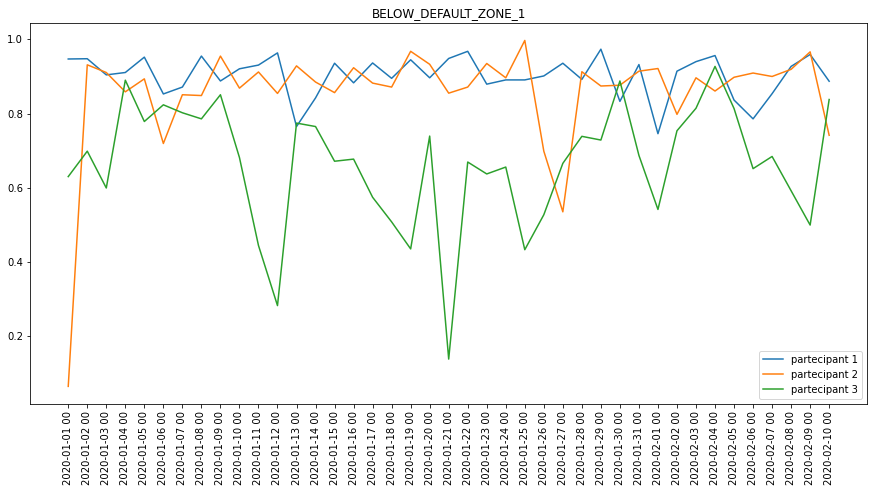

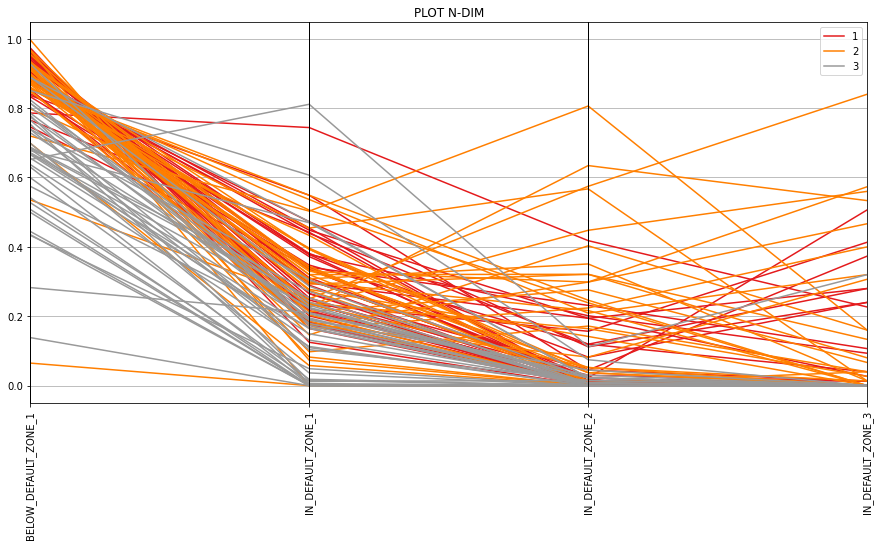

In [8]:
# Serie temporale con più di un attributo
df = time_in_heart_rate_zones
col_names = get_continuous_attributes(df)

if want_normalize:
    df = df.copy()
    df[col_names] = min_max_norm(df[col_names])

interval = ['2020-01-01','2020-02-10']
plot_2D(df, people, time_interval=interval, col_name=col_names[0], aggregation_level='HOUR', k=2)

if len(col_names) > 1:
    # con questo tipo di grafico perdiamo l'informazione temporale
    plot_ND(df, people, time_interval=interval, col_names=col_names, aggregation_level='HOUR', title="PLOT N-DIM")

C:\Users\Davide\.conda\envs\dmkd\lib\site-packages\ipykernel_launcher.py:117: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.


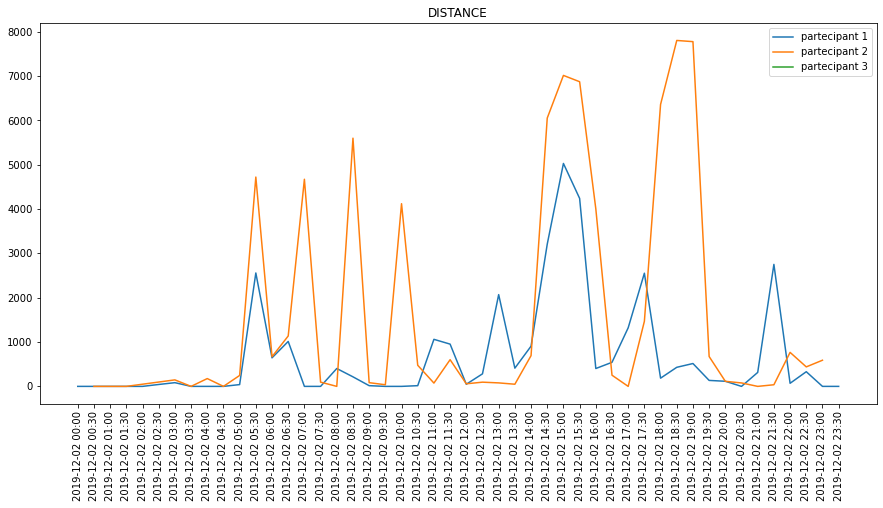

In [11]:
# Serie temporale con granularità per minuto
df = distance
col_names = get_continuous_attributes(df)

interval = ['2019-12-02 00','2019-12-02 23']
plot_2D(df, people, time_interval=interval, col_name=col_names[0], aggregation_level='MINUTE', k=30)